In [1]:
using Pkg; Pkg.activate(".")
using Random, Distributions, LinearAlgebra, Statistics
using Plots, Plots.PlotMeasures, StatsPlots, LaTeXStrings
using Zygote, Flux, Turing, MCMCChains, AdvancedMH, Optim, AdvancedHMC
using DistributionsAD, AdvancedVI, Distributions
using DiffEqFlux, DifferentialEquations, DiffEqCallbacks
using LinearAlgebra, SymPy, StatsBase
using AdaptiveMCMC, DataFrames, KernelDensity
using CSV, Trapz, QuadGK, DelimitedFiles, Optim

  Activating new project at `~/Library/CloudStorage/OneDrive-UCB-O365/SpringMassDamper/RoundRobin/third`


In [2]:
times = readdlm("../mass-spring-dampers/experimental_data/k1m3h1/times.mat", Float32)
expTimes = vcat(times[1,1:end])
filteredTimes = filter(x -> 0.01<=x<=0.5, expTimes)
expTimes2 = filteredTimes

2509-element Vector{Float32}:
 0.010117556
 0.010312872
 0.010508188
 0.010703504
 0.01089882
 0.011094136
 0.011289452
 0.011484768
 0.011680084
 0.0118754
 0.012070716
 0.012266032
 0.012461348
 ⋮
 0.49782178
 0.4980171
 0.49821243
 0.49840775
 0.49860305
 0.49879837
 0.4989937
 0.499189
 0.4993843
 0.49957964
 0.49977496
 0.49997026

In [3]:
indices = findall(x -> 0.01 <= x <= 0.5, expTimes)

2509-element Vector{Int64}:
  104
  105
  106
  107
  108
  109
  110
  111
  112
  113
  114
  115
  116
    ⋮
 2601
 2602
 2603
 2604
 2605
 2606
 2607
 2608
 2609
 2610
 2611
 2612

In [4]:
#Defining Constants
D = 0.0485
Df = 0.001

m=1.0613
mf=9.33

k = 26912.6
b = 1.70338
g0 =26.1782
kf = 180.714
bf = 0.176391

uInitial = [0.019893, 0.0200593, 0.00754123, 0.00832097]
u0=uInitial

tspan = (expTimes2[1], expTimes2[end])
storedTimes = expTimes2
inadType=1

params = [k,b,bf,g0,kf]
pTrue = vcat(params,u0)

# For high fidelity
ki = 25788
bi = 18.206
g0i =26
kfi = 722.0
bfi = 0.176

k1=40000
k2=5

mi=1.0613
mfi=9.33

paramsHigh =[ki,bi,bfi,g0i,kfi,k1,k2]
pTrueHigh=vcat(paramsHigh,u0)

11-element Vector{Float64}:
 25788.0
    18.206
     0.176
    26.0
   722.0
 40000.0
     5.0
     0.019893
     0.0200593
     0.00754123
     0.00832097

In [5]:
function lowFidelity(du,u,p,t)
    k = p[1]
    b = p[2]
    bf = p[3]
    g0 = p[4]
    kf = p[5]

    if inadType == 1 || inadType == 2
        x = u[1:2]
        v = u[3:4]
        
        du[1:2]=v
        
        du[3]=(1/m)*(-b*(v[1]-v[2])-g0*v[1]-k*(x[1]-x[2]))
        du[4]=(1/mf)*(b*(v[1]-v[2])+k*(x[1]-x[2])-bf*v[2]-kf*x[2])
    end
    return du
end

function highFidelity(du,u,p,t)
    ki = p[1]
    bi = p[2]
    bfi = p[3]
    g0i = p[4]
    kfi = p[5]

    k1 = p[6]
    k2 = p[7]

    if inadType == 3 || inadType == 4
        x = u[1:2]
        v = u[3:4]
        
        du[1:2]=v
        
        du[3]=(1/mi)*(-bi*(v[1]-v[2])-g0i*v[1]-(ki*(x[1]-x[2])+k1*abs(x[1]-x[2])*(x[1]-x[2])+k2*(x[1]-x[2])^3))
        du[4]=(1/mfi)*(bi*(v[1]-v[2])+ki*(x[1]-x[2])-bfi*v[2]-kfi*x[2])
    end
    return du
end

highFidelity (generic function with 1 method)

In [6]:
function takeDerivs(p; fp=false)
    vals = SavedValues(Float64, Vector{Float64})
    cb = SavingCallback((u,t,integrator)->integrator(t,Val{1}), vals, saveat=storedTimes)
    lowFidel = ODEProblem(lowFidelity, p[6:9],tspan,p)
    sol = Array(solve(lowFidel,RadauIIA5(), u0=p[6:9], p=p,saveat=storedTimes, reltol=1e-4, abstol=1e-4, callback=cb))
        
    derivs = mapreduce(permutedims, vcat, vals.saveval)
    
    return sol, derivs
end

function takeDerivsInad(p; fp=false)
    vals = SavedValues(Float64, Vector{Float64})
    cb = SavingCallback((u,t,integrator)->integrator(t,Val{1}), vals, saveat=storedTimes)
    highFidel = ODEProblem(highFidelity, p[8:11],tspan,p)
    sol = Array(solve(highFidel,RadauIIA5(), u0=p[8:11], p=p,saveat=storedTimes, reltol=1e-4, abstol=1e-4, callback=cb))
        
    derivs = mapreduce(permutedims, vcat, vals.saveval)
    
    return sol, derivs
end

takeDerivsInad (generic function with 1 method)

In [7]:
#solution, derivatives = takeDerivs(pTrue)

In [8]:
data_accm = readdlm("../mass-spring-dampers/experimental_data/k1m3h1/acc_output5.mat", Float32)
data_accm_pr = vcat(data_accm[1,1:end])
data_accmf = readdlm("../mass-spring-dampers/experimental_data/k1m3h1/acc_w_output5.mat", Float32)
data_accmf_pr = vcat(data_accm[1,1:end])

accm = data_accm_pr[104:2612, :]
accf = data_accmf_pr[104:2612, :]

2509×1 Matrix{Float32}:
 4.7798905
 4.848705
 4.887001
 4.905551
 4.884608
 4.8630657
 4.8283596
 4.7786937
 4.7380037
 4.6841493
 4.6290975
 4.556095
 4.4806986
 ⋮
 0.052059397
 0.04966586
 0.054452933
 0.052657783
 0.04966586
 0.051461015
 0.055051316
 0.04966586
 0.048469096
 0.051461015
 0.055051316
 0.05086263

In [9]:
# # plot(storedTimes,accm)
# # plot!(storedTimes, derivatives[:,3])
# # xlims!(0,0.5)

# plot(storedTimes,accm, label ="experiment",title="m=2 and k=1", linewidth=1.5, color=:blue)
# plot!(storedTimes, derivatives[:,3], label="low fidelity", linestyle=:dash, linewidth=2, color=:red)
# xlabel!("Time")
# ylabel!("Acceleration")
# #savefig("RRLogNormalm2k1_not_recal.png")

In [27]:
dfInad = CSV.read("logNormalMCMCChains_M1K1_No_Hyper_Trial6_200000_L5_Inad.csv", DataFrame)
df = CSV.read("logNormalMCMCChains_M1K1_No_Hyper_Trial3_200000_L5_Updated_Priors_2.csv", DataFrame)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
2,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
3,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
4,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
5,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
6,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
7,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
8,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
9,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707


In [29]:
dfInad 

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,26891.4,10.6128,0.178966,22.7402,427.133,520.896,19926.5,0.00501586,0.00520786,0.0270032,0.0262771
2,26927.0,10.6178,0.176261,22.4024,452.252,437.181,19594.4,0.00473639,0.00492806,0.0270615,0.0267033
3,26927.0,10.6178,0.176261,22.4024,452.252,437.181,19594.4,0.00473639,0.00492806,0.0270615,0.0267033
4,26927.0,10.6178,0.176261,22.4024,452.252,437.181,19594.4,0.00473639,0.00492806,0.0270615,0.0267033
5,26927.0,10.6178,0.176261,22.4024,452.252,437.181,19594.4,0.00473639,0.00492806,0.0270615,0.0267033
6,26927.0,10.6178,0.176261,22.4024,452.252,437.181,19594.4,0.00473639,0.00492806,0.0270615,0.0267033
7,26927.0,10.6178,0.176261,22.4024,452.252,437.181,19594.4,0.00473639,0.00492806,0.0270615,0.0267033
8,26927.0,10.6178,0.176261,22.4024,452.252,437.181,19594.4,0.00473639,0.00492806,0.0270615,0.0267033
9,26940.6,10.5844,0.176107,22.4154,457.3,437.912,19681.3,0.00465478,0.00484661,0.0270943,0.02682


In [28]:
sdf = df[1:200:end, :]
sdfInad = dfInad[1:200:end, :]

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,26891.4,10.6128,0.178966,22.7402,427.133,520.896,19926.5,0.00501586,0.00520786,0.0270032,0.0262771
2,26929.3,10.8334,0.179328,22.516,444.949,423.35,19806.7,0.00499682,0.00519117,0.0273029,0.0268321
3,26957.1,10.1921,0.175331,22.8754,453.431,438.288,20182.5,0.00459653,0.00478915,0.0271625,0.0267064
4,26976.5,10.9473,0.172229,22.4359,466.38,502.021,19817.5,0.00446568,0.00465951,0.0273486,0.0272687
5,26889.9,10.4496,0.175571,22.703,438.362,503.608,20352.1,0.00455412,0.00474815,0.0273063,0.0268409
6,26909.1,10.5017,0.178036,22.7381,437.664,422.057,19985.0,0.00501092,0.00520356,0.0270827,0.0266063
7,26976.7,10.1216,0.177175,22.6962,459.515,461.683,20808.7,0.00434869,0.00454063,0.027146,0.0269022
8,26966.0,10.4159,0.17753,22.6326,453.201,436.758,20491.4,0.00455094,0.00474341,0.0271786,0.0268948
9,26964.3,10.4509,0.175745,22.5319,432.977,432.942,20217.3,0.00503632,0.00522741,0.0269465,0.0267224


In [12]:
nTrajInad=801
nTraj=1201

1201

In [13]:
scombinedpsInad = [ [sdfInad[:, :x1][i], sdfInad[:, :x2][i], sdfInad[:, :x3][i], sdfInad[:, :x4][i], sdfInad[:, :x5][i], sdfInad[:, :x6][i], sdfInad[:, :x7][i], sdfInad[:, :x8][i], sdfInad[:, :x9][i], sdfInad[:, :x10][i], sdfInad[:, :x11][i]] for i in 1:nTrajInad ]
scombinedps = [ [sdf[:, :x1][i], sdf[:, :x2][i], sdf[:, :x3][i], sdf[:, :x4][i], sdf[:, :x5][i], sdf[:, :x6][i], sdf[:, :x7][i], sdf[:, :x8][i], sdf[:, :x9][i]] for i in 1:nTraj ]


1201-element Vector{Vector{Float64}}:
 [27057.5178197034, 10.529387429054468, 0.17682238902072256, 22.72929012280119, 456.905281819236, 0.004619358710235171, 0.0048115601014465095, 0.026128773089968346, 0.027770735774962037]
 [27044.9154665999, 10.608883977200906, 0.176254496539885, 22.844963581138984, 453.08723735979464, 0.004726375931217274, 0.004919214832242565, 0.02615789389821738, 0.02776788010708422]
 [27042.084578849554, 10.68491713181883, 0.1752323010139153, 22.792439498058524, 436.50926080784564, 0.005083333715064677, 0.005276159209617795, 0.026101298307203872, 0.027739764469303815]
 [27048.25069744082, 10.61074980546265, 0.1761713472447085, 22.70110438521588, 450.51862243908755, 0.00482496057264166, 0.0050177039047272455, 0.02618009903746026, 0.027747236717647332]
 [27043.596595996823, 10.600588128436774, 0.17650709615882482, 22.73989321912171, 451.8011063877976, 0.00479599324367715, 0.004988928626606704, 0.026200395363788848, 0.02777066764144088]
 [27039.6732021092, 10.60954

In [14]:
inadType=1
MCMC_results=[]
for param in scombinedps
    pTrue = param
    
    solution, derivatives = takeDerivs(pTrue)
    
    push!(MCMC_results, (derivatives[:,3]))
end
    

In [15]:
inadType=3
MCMC_resultsInad=[]
for param in scombinedpsInad
    pTrue = param
    
    solution, derivatives = takeDerivsInad(pTrue)
    
    push!(MCMC_resultsInad, (derivatives[:,3]))
end

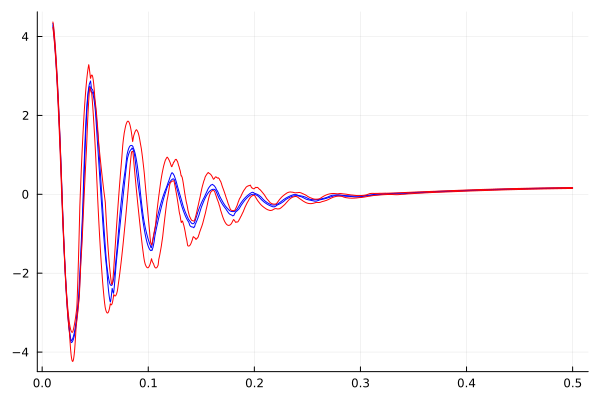

In [16]:
ytrajectories = [MCMC_results[i] for i in 1:nTraj]
trajectories = hcat(ytrajectories...)

quantilesToPlot = [0.25,0.75,0.025,0.975]
function computeQuantiles(data, quantiles)
    return [quantile(data, q) for q in quantiles]
end

quantile_data = mapslices(data -> computeQuantiles(data, quantilesToPlot), trajectories, dims=2)

quantile50L = quantile_data[:, 1]
quantile50U = quantile_data[:, 2]
quantile95L = quantile_data[:, 3]
quantile95U = quantile_data[:, 4]

plot(storedTimes, quantile50L, label=nothing, color=:blue)
plot!(storedTimes, quantile50U, label=nothing, color=:blue)
plot!(storedTimes, quantile95L, label=nothing, color=:red)
plot!(storedTimes, quantile95U, label=nothing, color=:red)

In [17]:
saverage_trajectory = mean(trajectories, dims=2)
savg = vec(saverage_trajectory)

2509-element Vector{Float64}:
 4.299223766301047
 4.260840264103539
 4.219382100585854
 4.174849275954875
 4.127241789589961
 4.074069722504453
 4.015991989079156
 3.9554183479637324
 3.892348799749908
 3.8267833441438457
 3.758721981808412
 3.6881647119447845
 3.6151115338493875
 ⋮
 0.15999941879945329
 0.16005088680665697
 0.16010195462178708
 0.1601526004024677
 0.16020285710205476
 0.16025273994587558
 0.16030220955296665
 0.16035126320345078
 0.16039992927431604
 0.1604482105486107
 0.16049618419990647
 0.1605437861821266

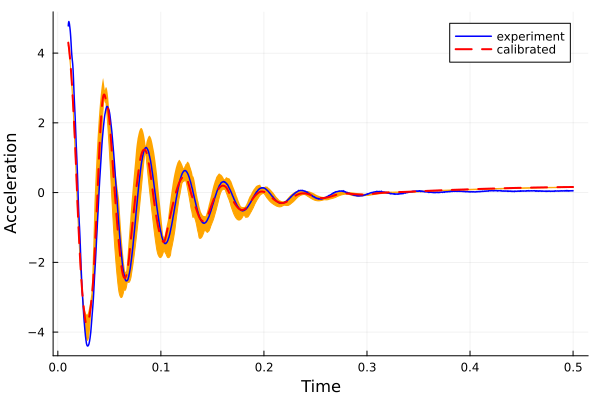

In [18]:
fill50=plot(storedTimes,quantile50L,fillrange=quantile50U, fillalpha=0.75, fillcolor=:orange,color=:orange, label=nothing)
fill95=plot(storedTimes,quantile95L,fillrange=quantile95U, fillalpha=1.0, fillcolor=:orange,color=:orange, label=nothing)

p4=plot(fill50)
p4=plot!(fill95)
p4=plot!(storedTimes,accm, label ="experiment", linewidth=1.5, color=:blue)
p4=plot!(storedTimes, savg, label="calibrated", linestyle=:dash, linewidth=2, color=:red)
xlabel!("Time")
ylabel!("Acceleration")
#savefig("calibrated_lognormal_m3k1_graph.png")

In [19]:
seedNum=1000
function predictiveAssessment(enriched, observed; alpha =0.05)
    numObs = length(observed)
    gammas = zeros(numObs)
    numSamples = (size(enriched)[2])
    Random.seed!(seedNum)
    numObsError = 100
    
    predictions = zeros(numSamples, numObs)

    postPred = zeros(numObs, numSamples*numObsError)
    
    for j in 1:numObs      
        for k in 1:numSamples
            mu = enriched[j,k]
            postPred[j,(k-1)*numObsError+1:(k-1)*numObsError+numObsError]= rand(Normal(mu,0.1),numObsError)
        end
        density = kde(postPred[j,:])
        ik=InterpKDE(density)
        minf = minimum(postPred[j,:])
        maxf = maximum(postPred[j,:])
        xs = LinRange(minf,maxf,200)
        fpdf = pdf(ik,xs)
        fpdfLen = length(fpdf)
        pofy=pdf(ik,observed[j])
            
        for l in 1:fpdfLen
            if fpdf[l]>pofy
                fpdf[l]=0.
            end
        end
        gamma = -trapz(fpdf,xs)
        gammas[j]=gamma
    end
    return gammas, postPred
    
end

function fractionGamma(gamma;alpha=0.05)
    numObs = length(gamma)
    tau = alpha/numObs
    count = 0
    for i in 1:numObs
        if gamma[i]<tau
            count+=1
        end
    end
    count/numObs
end

fractionGamma (generic function with 1 method)

In [101]:
Gs=predictiveAssessment(trajectories,accm)

([4.5374377839067423e-7, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  0.29477843868213616, 0.2821988920554756, 0.2701159598291827, 0.2763708720051119, 0.28907137173095127, 0.26653272782381054, 0.25957998775027885, 0.27693970393457285, 0.2997018324336489, 0.27322654874698943], [4.149362127051232 4.551506048032347 … 4.4188898729381725 4.372701594502678; 4.355929268352908 4.383529638154373 … 4.284855293505737 4.205024691222749; … ; 0.19674281924696857 0.12380744664352922 … 0.3248028245439673 0.2523889045035446; 0.07875381786772301 0.1964750915734377 … 0.2588608639568949 0.1915831852432751])

In [102]:
GammaVals = Gs[1]
posteriors=Gs[2]

2509×120100 Matrix{Float64}:
 4.14936    4.55151     4.34873    …  4.31563     4.41889     4.3727
 4.35593    4.38353     4.3191        4.19653     4.28486     4.20502
 4.2129     4.21556     4.41293       4.11517     4.3502      4.15361
 4.26987    4.20857     4.21046       4.08048     4.22889     4.0737
 4.36811    4.13629     4.29507       4.2565      4.3246      4.07094
 4.24217    4.2802      4.43582    …  4.16782     4.01861     4.21796
 4.13568    4.01618     4.12836       4.13618     4.02536     3.80559
 3.96828    4.33128     4.16379       3.87746     3.83156     4.02001
 4.03544    3.7678      4.14289       3.80021     3.9779      3.88469
 3.9747     4.11709     3.86462       3.82717     4.09007     3.86127
 3.85486    3.90957     3.66741    …  3.769       3.89124     3.81359
 3.85534    3.66796     3.92253       3.78243     3.84636     3.72377
 3.81716    3.69531     3.75202       3.41072     3.5959      3.74471
 ⋮                                 ⋱                          


In [103]:
fractionGamma(GammaVals)

0.061777600637704266

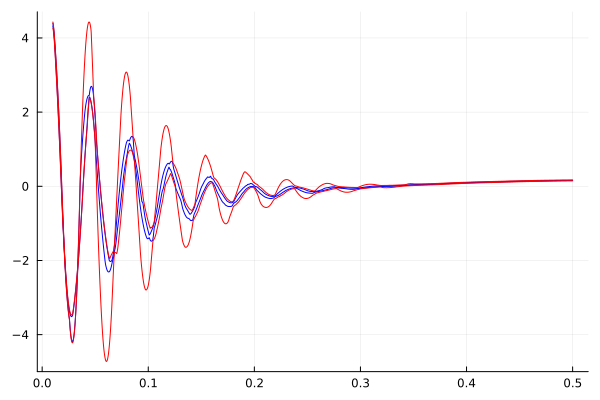

In [20]:
ytrajectoriesInad = [MCMC_resultsInad[i] for i in 1:nTrajInad]
trajectoriesInad = hcat(ytrajectoriesInad...)

quantile_dataInad = mapslices(data -> computeQuantiles(data, quantilesToPlot), trajectoriesInad, dims=2)

quantile50LInad = quantile_dataInad[:, 1]
quantile50UInad = quantile_dataInad[:, 2]
quantile95LInad = quantile_dataInad[:, 3]
quantile95UInad = quantile_dataInad[:, 4]

plot(storedTimes, quantile50LInad, label=nothing, color=:blue)
plot!(storedTimes, quantile50UInad, label=nothing, color=:blue)
plot!(storedTimes, quantile95LInad, label=nothing, color=:red)
plot!(storedTimes, quantile95UInad, label=nothing, color=:red)

In [21]:
average_trajectoryInad = mean(trajectoriesInad, dims=2)
avgInad = vec(average_trajectoryInad)

2509-element Vector{Float64}:
 4.361011331953205
 4.328681242574174
 4.291694664608311
 4.250051598260364
 4.203752042916134
 4.142191871010753
 4.066409755832491
 3.988600650814467
 3.908764557199615
 3.8269014736719407
 3.7430114008239506
 3.6570943387230974
 3.5691502852370895
 ⋮
 0.1577957482696089
 0.1578487869541939
 0.1579014524967977
 0.15795372717936218
 0.15800564914377654
 0.15805721927218952
 0.1581084481739387
 0.15815935012480686
 0.1582099324883276
 0.15826015779907615
 0.15831001224935526
 0.15835950604215643

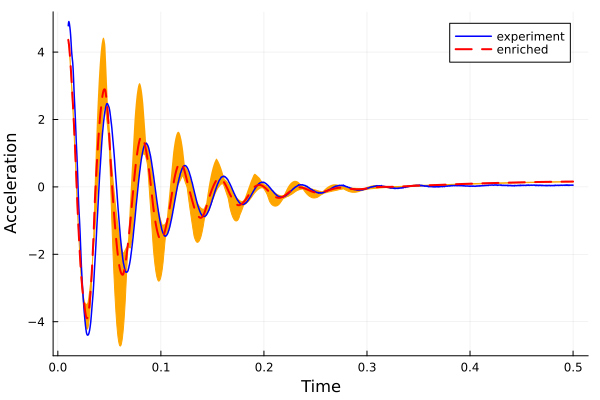

In [22]:
fill50Inad=plot(storedTimes,quantile50LInad,fillrange=quantile50UInad, fillalpha=0.75, fillcolor=:orange,color=:orange, label=nothing)
fill95Inad=plot(storedTimes,quantile95LInad,fillrange=quantile95UInad, fillalpha=1.0, fillcolor=:orange,color=:orange, label=nothing)

p3=plot(fill50Inad)
p3=plot!(fill95Inad)
p3=plot!(storedTimes,accm, label ="experiment", linewidth=1.5, color=:blue)
p3=plot!(storedTimes, avgInad, label="enriched", linestyle=:dash, linewidth=2, color=:red)
xlabel!("Time")
ylabel!("Acceleration")
#savefig("enriched_lognormal_m3k1_graph.png")

In [23]:
GsInad=predictiveAssessment(trajectoriesInad,accm)

([-0.00013564790365002902, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  0.3041591559279262, 0.29664412403627893, 0.28603986978858353, 0.30269871557754585, 0.31375423169763533, 0.29178195103388493, 0.2764733612706743, 0.2920093072809002, 0.30855227349488024, 0.28671733556768897], [4.071646706226147 4.473790627207262 … 4.324803315150354 4.396360593465139; 4.333815516591983 4.183091933226923 … 4.392086243556636 4.134308839275541; … ; 0.022334336014423514 0.043886867842614266 … 0.08986049113759706 0.14770418206313624; 0.1506049689349912 0.05013687548689558 … -0.010170583474031563 0.14654005371357923])

In [24]:
GammaValsInad = GsInad[1]
posteriorsInad=GsInad[2]

2509×80100 Matrix{Float64}:
 4.07165     4.47379    4.27102    …  4.50441    4.3248     4.39636
 4.33382     4.18309    4.16402       4.2311     4.39209    4.13431
 4.24421     4.24775    4.1728        4.2208     4.42732    4.17666
 4.22248     3.97064    4.01158       4.32092    4.18252    3.93958
 3.89622     4.00703    3.98848       4.24742    4.34571    4.2319
 4.06722     4.11092    3.91941    …  4.03074    4.16029    4.17887
 4.08743     4.08691    4.04748       4.06014    4.08388    4.02349
 3.86939     3.80739    3.76976       4.03151    3.9935     4.05109
 3.8266      3.81234    3.90525       3.92217    3.98955    3.96572
 3.8897      3.73361    3.71643       3.90064    3.90087    4.02426
 3.70839     3.60233    3.76514    …  3.74713    3.78004    3.92619
 3.7286      3.76845    3.70862       3.68042    3.6988     3.73933
 3.40022     3.33755    3.4993        3.66794    3.62764    3.66841
 ⋮                                 ⋱                        
 0.122226   -0.0203789  0.16

In [109]:
fractionGamma(GammaValsInad)

0.09366281387006775